dataset/images/spam/spam_29322.050.gif: broken data stream when reading image file
dataset/images/spam/.DS_Store: cannot identify image file 'dataset/images/spam/.DS_Store'
(15164, 3)
Epoch 1/10
380/380 [==============================] - 125s 326ms/step - loss: 0.5784 - accuracy: 0.8773 - val_loss: 0.4187 - val_accuracy: 0.8856
Epoch 2/10
380/380 [==============================] - 122s 321ms/step - loss: 0.4928 - accuracy: 0.8861 - val_loss: 0.4045 - val_accuracy: 0.8856
Epoch 3/10
380/380 [==============================] - 122s 321ms/step - loss: 0.4713 - accuracy: 0.8861 - val_loss: 0.3968 - val_accuracy: 0.8856
Epoch 4/10
380/380 [==============================] - 122s 321ms/step - loss: 0.4609 - accuracy: 0.8861 - val_loss: 0.4017 - val_accuracy: 0.8856
Epoch 5/10
380/380 [==============================] - 123s 322ms/step - loss: 0.4489 - accuracy: 0.8861 - val_loss: 0.3887 - val_accuracy: 0.8856
Epoch 6/10
380/380 [==============================] - 122s 322ms/step - loss: 0.4421 -

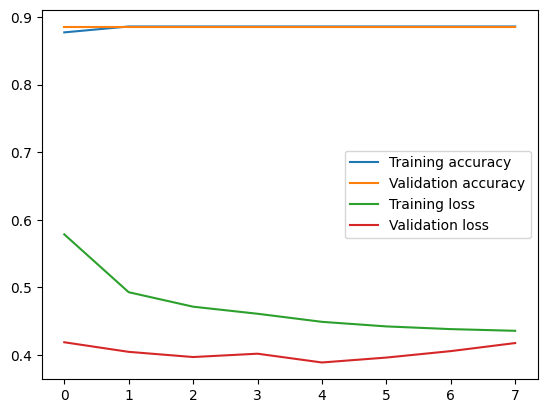

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import random
import shutil
import cv2
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array


def load_images_labels(data_dir):
    images = []
    labels = []
    class_dirs = ['ham', 'natural', 'spam']

    for label, class_dir in enumerate(class_dirs):
        class_path = os.path.join(data_dir, class_dir)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                img = Image.open(image_path)
                img.verify()
                img = load_img(image_path, target_size=img_size)
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"{image_path}: {e}")
    return np.array(images), np.array(labels)

# Define the directories for the training, validation, and test sets
data_dir = 'dataset/images'

# Define the image size and number of classes
img_size = (224, 224)
# img_size = (150, 150)
num_classes = 3

# Define the batch size and number of epochs
batch_size = 32
epochs = 10

# Load the images and labels
images, labels = load_images_labels(data_dir)
# Convert labels to one-hot encoding
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=3)
print(labels_one_hot.shape)

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)

# Create an instance of the ImageDataGenerator class for data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255)

# Use flow method to load the dataset
train_data_generator = data_augmentation.flow(x_train, y_train, batch_size=batch_size)

# Load the pre-trained VGG16 model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the weights of the base model
base_model.trainable = False

# Define the model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model with different optimizers
adam = tf.keras.optimizers.legacy.Adam()
sgd = tf.keras.optimizers.legacy.SGD()
rmsprop = tf.keras.optimizers.legacy.RMSprop()

model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model with early stopping
history = model.fit(train_data_generator, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stopping])

# Plot the training and validation accuracy and loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()



In [3]:
# # Save the model
# from keras.models import load_model
# model.save('model.h5')

# # Load tghe model
# model = load_model('model.h5')

# Define a predict function
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
def predict(image_path):
    # Load the image and preprocess it
    img = load_img(image_path, target_size=img_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Make the prediction
    predictions = model.predict(x)
    predicted_class = np.argmax(predictions)
    return predicted_class



In [4]:
# Call the predict function on a test image
test_image_path = '/Users/ivan/Code/comp3000hk-computer-project/machine_learning/testing_images/image.png'
predicted_class = predict(test_image_path)
print('Predicted class:', "spam" if predicted_class == 2 else "natural" if predicted_class == 1 else "ham")


1/1 [==============================] - 1s 778ms/step
Predicted class: spam
